# Classification Models with Crypto

In [1]:
# libraries
import pandas as pd
import random
from ta import add_all_ta_features
from datetime import datetime, timedelta
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import plotly.express as px
from tqdm import tqdm
from eod_historical_data import get_eod_data
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

# 1. Getting Crypto Price Data

In [2]:
# Importing and assigning the api key
with open("../eodHistoricalData-API.txt", "r") as f:
    api_key = f.read()
    

def getCryptoPrice(api_key, ticker="BTC-USD", n_days=1000):
    
    # Time periods
    now = datetime.now()

    # How far back to retrieve
    ago = now - timedelta(days=n_days)

    # Getting the price history for the crypto
    df = get_eod_data(
        ticker, 
        "CC", 
        api_key=api_key, 
        start=ago, 
        end=now
    )
    

    # Dropping a column
    df.drop(
        ["Adjusted_close"], 
        axis=1,
        inplace=True
    )

    return df

In [59]:
df = getCryptoPrice(api_key, ticker="BTC-USD", n_days=500)

/Users/marcosantos/miniforge3/lib/python3.9/site-packages/eod_historical_data/data.py:41: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.



## Adding Technical Indicators

In [60]:
df = add_all_ta_features(
    df, 
    open="Open", 
    high="High", 
    low="Low", 
    close="Close", 
    volume="Volume", 
    fillna=True
)

/Users/marcosantos/miniforge3/lib/python3.9/site-packages/ta/trend.py:768: RuntimeWarning:

invalid value encountered in double_scalars

/Users/marcosantos/miniforge3/lib/python3.9/site-packages/ta/trend.py:772: RuntimeWarning:

invalid value encountered in double_scalars



# 2. Data Transformation/Preprocessing

In [61]:
def transformData(df, days=1):
    """
    Transforming data into X variables for training.  Uses percent change and 
    multiplies the percentage by 100 rounded to 2 decimal places.
    """
    # Transforming data
    new_df = df.pct_change(
        days
    ).apply(
        lambda x: round(x*100, 2)
    ).replace(
        [np.inf, -np.inf], 
        np.nan
    ).shift(1) # Compensating for indicator lookahead bias
    
    # Dropping Nans
    new_df = new_df.dropna(
        thresh=round(new_df.shape[1]*.7) # If 70% of the values in the row are Nans, drop the whole row
    ).dropna(
        axis=1,
        thresh=round(new_df.shape[0]*.7) # If 70% of the values in the columns are Nans, drop the whole column
    )
    
    # Determining percent change and setting it as -1, 0, and 1 as Sell, Do Nothing, and Buy respectively
    new_df['decision']= df['Open'].pct_change(
        days
    ).shift(
        -days
    ).apply(
        np.sign
    )
    
    # Saving the last value in the dataset for later
    last_val = new_df.tail(1).drop('decision',
                                   axis=1)

    # Dropping the last NaNs from the Y variable
    new_df = new_df.dropna(
        subset=['decision']
    )

    # Filling in the rest of the NaNs with the most recent value
    new_df = new_df.fillna(method='ffill').dropna()

    return new_df, last_val

In [62]:
n_df, last_val = transformData(df, days=1)

In [63]:
n_df

,Open,High,Low,Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,...,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr,decision
Date,,,,,,,,,,,,,,,,,,,,,
2020-07-08,2.75,0.30,1.60,-0.96,-18.68,-11.71,100.61,-36.10,-56.62,-0.77,...,-17.92,-0.01,-97.45,1.87,-0.84,-43.63,-134.52,-135.16,22.39,1.0
2020-07-09,-0.91,0.92,0.24,1.95,19.07,21.73,-59.72,51.43,218.68,16.77,...,-32.31,0.10,16873.55,-20.60,-4.66,449.98,-302.43,-299.51,-36.68,-1.0
2020-07-10,1.89,-0.22,-0.45,-2.05,-9.23,-13.90,134.56,4.04,-85.37,1.19,...,-35.10,-0.00,-18.39,-6.37,-4.93,0.98,-205.08,-207.20,62.05,1.0
2020-07-11,-2.05,-1.47,-0.71,0.52,-11.42,18.72,-50.81,4.10,91.96,1.89,...,-48.67,-0.00,-33.57,11.85,-2.27,-56.18,-125.21,-124.88,-9.45,-1.0
2020-07-12,0.53,-0.06,0.78,-0.45,-14.56,-1.44,88.27,33.74,-56.11,12.10,...,-28.94,-0.00,-59.20,26.61,2.96,-227.36,-187.98,-188.41,9.23,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-17,7.38,-0.52,5.85,-0.95,-31.78,-0.82,-3.64,-26.18,-20.19,0.28,...,6.28,0.80,-14.58,-11.19,19.31,-36.33,-113.35,-113.88,-1.12,1.0
2021-10-18,-1.21,-1.03,-1.43,1.11,-14.57,1.79,3.23,61.76,-6.91,-6.97,...,4.42,1.67,-17.58,-27.74,3.81,-76.47,-217.72,-216.51,1.33,1.0
2021-10-19,1.12,1.42,1.39,0.63,28.40,1.25,4.02,31.61,-8.43,0.55,...,6.31,1.48,-38.97,7.58,4.67,27.38,-43.08,-42.94,0.75,1.0


# 3. Fitting to Classification Model

In [64]:
# Train, test, split
X = n_df.drop('decision', axis=1)

y = n_df['decision']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20
)

## Getting a Baseline Model
Using dummy classifier

In [65]:
# Fitting and training the dummy
dummy = DummyClassifier(
    strategy='uniform'
)
dummy.fit(X_train, y_train)

# Dummy predictions
dum_pred = dummy.predict(X_test)

#Printing out results
report = classification_report(y_test, dum_pred)
print(report)

              precision    recall  f1-score   support

        -1.0       0.49      0.47      0.48        49
         1.0       0.46      0.48      0.47        46

    accuracy                           0.47        95
   macro avg       0.47      0.47      0.47        95
weighted avg       0.47      0.47      0.47        95



## Using an Actual Classification Model

In [66]:
# Fitting and training
dec_tree = DecisionTreeClassifier()
dec_tree.fit(X_train, y_train)

# Predictions
preds = dec_tree.predict(X_test)

#Printing out results
report = classification_report(y_test, preds)
print(report)

              precision    recall  f1-score   support

        -1.0       0.48      0.33      0.39        49
         1.0       0.47      0.63      0.54        46

    accuracy                           0.47        95
   macro avg       0.48      0.48      0.46        95
weighted avg       0.48      0.47      0.46        95



# 4. Getting Classification Reports from Other Models

In [67]:
# Other models
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

models = {
    "adaboost":AdaBoostClassifier, 
    "gradboost":GradientBoostingClassifier, 
    "rf":RandomForestClassifier, 
    "knn":KNeighborsClassifier,
    "logreg":LogisticRegression, 
    "nb":GaussianNB, 
    "svm":SVC,
    "dummy": DummyClassifier
}

In [68]:
for model_name, model in models.items():
    
    # Fitting 
    clf = model()
    
    clf.fit(X_train, y_train)
    
    # Predictions
    preds = clf.predict(X_test)

    #Printing out results
    report = classification_report(y_test, preds)
    print(model_name+"\n",report)

adaboost
               precision    recall  f1-score   support

        -1.0       0.49      0.35      0.40        49
         1.0       0.47      0.61      0.53        46

    accuracy                           0.47        95
   macro avg       0.48      0.48      0.47        95
weighted avg       0.48      0.47      0.46        95

gradboost
               precision    recall  f1-score   support

        -1.0       0.46      0.22      0.30        49
         1.0       0.46      0.72      0.56        46

    accuracy                           0.46        95
   macro avg       0.46      0.47      0.43        95
weighted avg       0.46      0.46      0.43        95

rf
               precision    recall  f1-score   support

        -1.0       0.47      0.16      0.24        49
         1.0       0.47      0.80      0.60        46

    accuracy                           0.47        95
   macro avg       0.47      0.48      0.42        95
weighted avg       0.47      0.47      0.41      

/Users/marcosantos/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/marcosantos/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/marcosantos/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` pa

# 5. Backtesting Each Model

In [51]:
def fitModels(new_df):
    """
    From a list of models. Fit and trains them to the dataframe.
    Returns the fitted models.
    """
    # Models
    models = {
        "adaboost":AdaBoostClassifier(), 
        "gradboost":GradientBoostingClassifier(), 
        "ranfor":RandomForestClassifier(), 
        "knn":KNeighborsClassifier(),
        "logreg":LogisticRegression(), 
        "naivebay":GaussianNB(), 
        "svm":SVC(),
        "dummy": DummyClassifier(strategy='uniform')
    }
    
    # Fitted models
    fitted = {}
    
    # Variables
    X = new_df.drop('decision', axis=1)

    y = new_df['decision']
    
    # Fitting each model
    for model_name, model in models.items():

        # Fitting 
        clf = model

        clf.fit(X, y)
        
        # Adding each fitted model to the fitted dictionary
        fitted[model_name] = clf

    return fitted

In [52]:
def backtestModels(ticker, days_to_backtest, days_to_train, api_key):
    """
    Backtests multiple classification models based on the given crypto ticker. Range of 
    backtest is dependent on days_to_backtest. Training data is dependent on days_to_train.
    """

    # Getting Data 
    df = getCryptoPrice(
        api_key=api_key,
        ticker=ticker, 
        n_days=days_to_backtest+days_to_train
    )

    # Creating a DF for predictions
    pred_df = pd.DataFrame()

    # Iterating through the DF starting from the least amount of days to train on
    for i in tqdm(range(days_to_train, len(df)+1)):

        # Training DF
        train_df = df[i-days_to_train:i]

        # Tranforming the Training DF
        t_df, last_val = transformData(train_df)

        # Fitting models
        fitted_models = fitModels(t_df)
        
        # Setting the new index to classify
        pred = pd.DataFrame(index=last_val.index+pd.offsets.Day(1))

        # Making classifications for the very next day
        for model_name, model in fitted_models.items():
                        
            pred[model_name] = model.predict(last_val)

        # Appending the classifications to the dataframe
        pred_df = pred_df.append(pred)

    # Getting log returns from the original DF
    log_returns = df['Open'].tail(len(pred_df)).apply(np.log).diff()
    
    # Dropping any Nans and compensating for lookahead bias
    pred_df = pred_df.shift(1).dropna()

    # Performing the backtest
    returns = pred_df.multiply(log_returns, axis=0)
    
    # Inversing the log returns and getting daily portfolio balance
    performance = returns.cumsum().apply(np.exp)
    
    return performance

## Running the Backtest

In [69]:
# API Key
with open("../eodHistoricalData-API.txt", "r") as f:
    api_key = f.read()

performance = backtestModels("BTC-USD", 365, 1000, api_key)

/Users/marcosantos/miniforge3/lib/python3.9/site-packages/eod_historical_data/data.py:41: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.

100%|██████████| 367/367 [01:49<00:00,  3.37it/s]


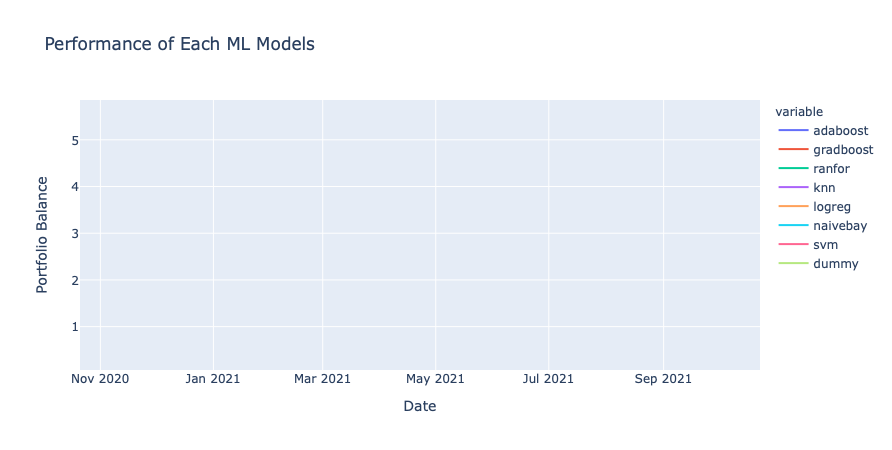

In [70]:
fig = px.line(
    performance,
    x=performance.index,
    y=performance.columns,
    title='Performance of Each ML Models',
    labels={"value": "Portfolio Balance",
            "ds": "Date"}
)

fig.show()